In [1]:
import numpy as np

# Unknown objective/black box function to Gaussian Process model
def black_box_function(x1, x2):
    y = x1 * np.sin(x1) * np.transpose(x2 * np.sin(x2))
    return y

# x1 and x2 are all possible values that the two parameters can each take on
x1 = np.linspace(start=0, stop=10, num=1_000).reshape(-1, 1)
x2 = np.linspace(start=0, stop=10, num=1_000).reshape(-1, 1)

# True function
y = black_box_function(x1, x2)

<ipython-input-2-9bc2038186f8>:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-poster')


Text(0.5, 0.92, 'True generative process')

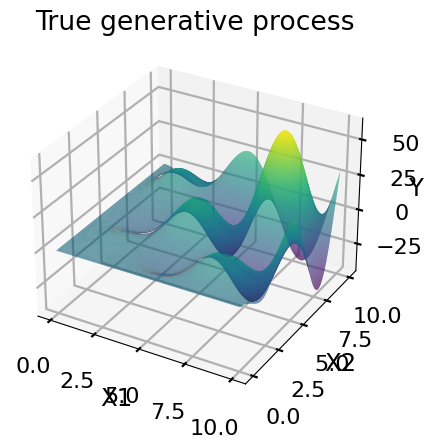

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

# Plots the true black box function for reference
fig = plt.figure()
plt.style.use('seaborn-poster')
ax = plt.axes(projection='3d')

X1, X2 = np.meshgrid(x1, x2)
ax.plot_surface(X1, X2, y, rstride=1, cstride=1, cmap='viridis', edgecolor='none')

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
ax.set_title('True generative process')

In [16]:
# Observes an initial number of samples of the unknown objective function
rng = np.random.RandomState(4)
# X1 and X2 are combined in a single matrix to be able to be inputted into GP
X = np.column_stack((X1.reshape(-1), X2.reshape(-1)))
y = y.reshape(-1,1)
training_indices = rng.choice(np.arange(len(X)), size=5, replace=False)
X_samples, y_samples = X[training_indices], y[training_indices]

In [4]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

# Obtains the kernel for the GP regression model
kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

# Fits the GP model with observed values
gaussian_process.fit(X_samples, y_samples)
gaussian_process.kernel_

# For some reason, run this until you get length_scale=0.746.
# However, the kernel is arbitrary since this is for example purposes.

15.6**2 * RBF(length_scale=0.746)

<ipython-input-5-2306dd73ca30>:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-poster')


Text(0.5, 0.92, 'Gaussian process regression on noise-free dataset')

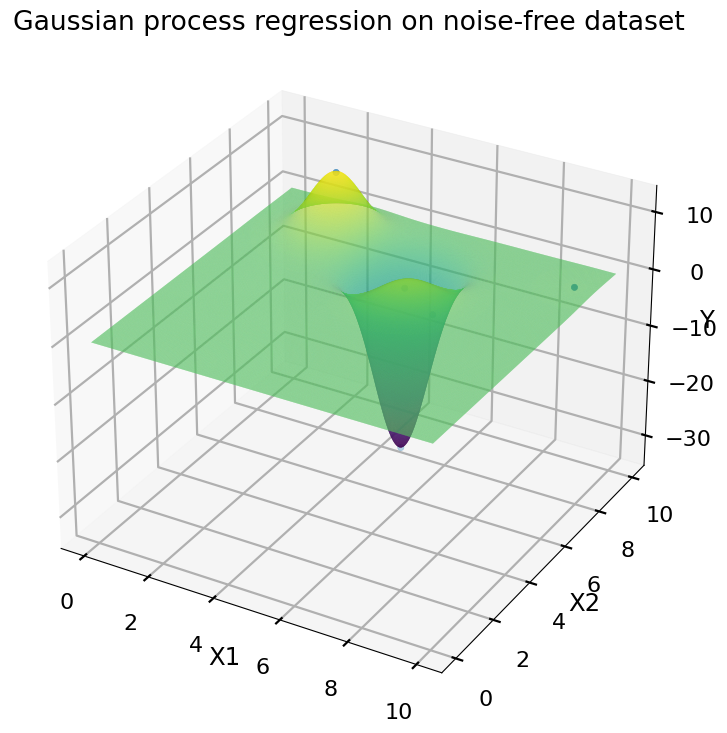

In [5]:
# Obtains the mean of all surrogate function predictions and the
# standard deviation, aka uncertainty
mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)
mean_pred = mean_prediction.reshape(X1.shape)
std_pred = std_prediction.reshape(X1.shape)

# Plots the first iteration of GP model with only mean prediction
fig = plt.figure()
plt.style.use('seaborn-poster')
ax = plt.axes(projection='3d')

ax.plot_surface(X1, X2, mean_pred, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.scatter(X_samples[:,0], X_samples[:,1], y_samples, label="Observations")

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
ax.set_title('Gaussian process regression on noise-free dataset')

<ipython-input-8-3d6c3bb95409>:22: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-poster')


Text(0.5, 0.92, 'Expected Improvement')

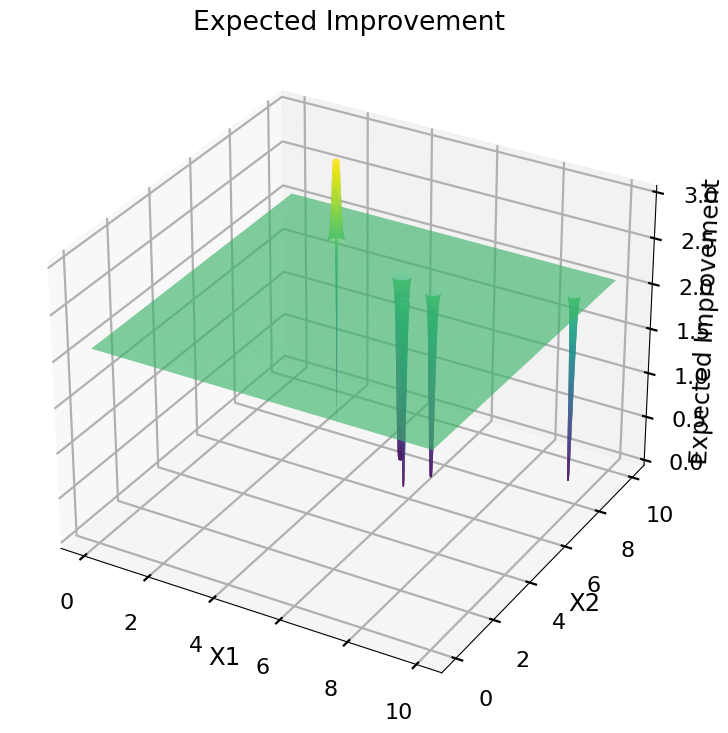

In [8]:
from scipy.stats import norm

# Determines the expected improvement across all values of X1 and X2
# relative to the best observed y value
def expected_improvement(X, gp_model, best_y):
    y_pred, y_std = gp_model.predict(X, return_std=True)
    z = (y_pred - best_y) / y_std
    ei = (y_pred - best_y) * norm.cdf(z) + y_std * norm.pdf(z)
    return ei

# Determines the best point with the highest observed function value
best_idx = np.argmax(y_samples)
best_x = X_samples[best_idx]
best_y = y_samples[best_idx]

# Obtain EI of all X1 and X2 value combinations
exp_imp = expected_improvement(X, gaussian_process, best_y)
ei = exp_imp.reshape(X1.shape)

# Plot the expected improvement
fig = plt.figure()
plt.style.use('seaborn-poster')
ax = plt.axes(projection='3d')

ax.plot_surface(X1, X2, ei, rstride=1, cstride=1, cmap='viridis', edgecolor='none')

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Expected Improvement')
ax.set_title('Expected Improvement')

In [17]:
# Iterates through GP a set number of times
num_iterations = 20

for i in range(num_iterations):

    # Fit the GP model to the samples
    X_samples = X_samples.reshape(-1,2)
    gaussian_process.fit(X_samples, y_samples)

    # Obtains the mean of all surrogate function predictions and the
    # standard deviation, aka uncertainty
    y_mean, y_std = gaussian_process.predict(X, return_std=True)
    y_pred = y_mean.reshape(X1.shape)

    # Determine the best point with the highest observed function value
    best_idx = np.argmax(y_samples)
    best_x = X_samples[best_idx,:]
    best_y = y_samples[best_idx]

    # Calculates the EI of all potential parameter X1 and X2 value combinations
    exp_imp = expected_improvement(X, gaussian_process, best_y)
    ei = exp_imp.reshape(X1.shape)

    # Prints all observed samples
    print(f"Iteration #{i+1}:")
    print("Currently Observed Samples: ")
    for j in range(len(y_samples)):
        print(f"{X_samples[j, 0]}, {X_samples[j, 1]}, {y_samples[j]}")

    if i < num_iterations - 1:
        # Select the next point with the highest EI
        new_x = X[np.argmax(exp_imp)]
        new_y = black_box_function(new_x[0], new_x[1])
        X_samples = np.vstack([X_samples, new_x])
        y_samples = np.vstack([y_samples, new_y])

        print(f"Selected Sample: {new_x[0]}, {new_x[1]}, {new_y}")
        print("\n")

# Note: GP's are not plotted due to them taking up all available RAM.

Iteration #1:
Currently Observed Samples: 
4.954954954954955, 7.4174174174174174, [-32.33086367]
5.7057057057057055, 6.226226226226226, [1.10404454]
2.5325325325325325, 8.108108108108109, [11.37017354]
6.106106106106106, 7.037037037037037, [-5.18075001]
9.41941941941942, 8.71871871871872, [0.28553481]
Selected Sample: 1.7817817817817818, 8.348348348348349, 12.803591394431523


Iteration #2:
Currently Observed Samples: 
4.954954954954955, 7.4174174174174174, [-32.33086367]
5.7057057057057055, 6.226226226226226, [1.10404454]
2.5325325325325325, 8.108108108108109, [11.37017354]
6.106106106106106, 7.037037037037037, [-5.18075001]
9.41941941941942, 8.71871871871872, [0.28553481]
1.7817817817817818, 8.348348348348349, [12.80359139]
Selected Sample: 1.8118118118118118, 7.4574574574574575, 12.102904259171838


Iteration #3:
Currently Observed Samples: 
4.954954954954955, 7.4174174174174174, [-32.33086367]
5.7057057057057055, 6.226226226226226, [1.10404454]
2.5325325325325325, 8.108108108108109